# Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fb = pd.read_csv(
    'data/fb_stock_prices_2018.csv', 
    index_col='date', 
    parse_dates=True
)

quakes = pd.read_csv('data/earthquakes.csv')

covid = pd\
    .read_csv('data/covid19_cases.csv')\
    .assign(
        date=lambda x: pd.to_datetime(x.dateRep, format='%d/%m/%Y')
    )\
    .set_index('date')\
    .replace('United_States_of_America', 'USA')\
    .sort_index()['2020-01-18':'2020-09-18']

# Exercise 1

Using seaborn , create a heatmap to visualize the correlation coefficients between
earthquake magnitude and whether there was a tsunami for earthquakes measured
with the mb magnitude type.

Text(0.5, 1.0, 'Correlation between earthquake magnitude\nand whether there was a tsunami')

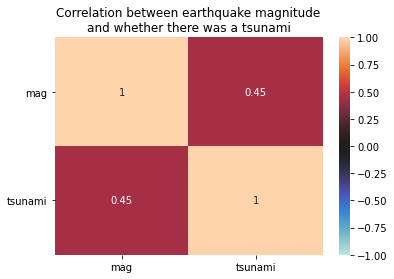

In [22]:
sns.heatmap(
    quakes\
        .query("magType=='mb'")\
        .loc[:,['mag', 'tsunami']]\
        .corr(),
    annot=True, 
    center=0, 
    vmin=-1, 
    vmax=1
)

plt.yticks(rotation=0)
plt.title(
    'Correlation between earthquake magnitude\n' + \
    'and whether there was a tsunami'
)

# Exercise 2

Create a box plot of Facebook volume traded and closing prices, and draw reference
lines for the bounds of a Tukey fence with a multiplier of 1.5. The bounds will be
at Q 1 − 1.5 × IQR and Q 3 + 1.5 × IQR. Be sure to use the quantile() method on
the data to make this easier. (Pick whichever orientation you prefer for the plot, but
make sure to use subplots.)

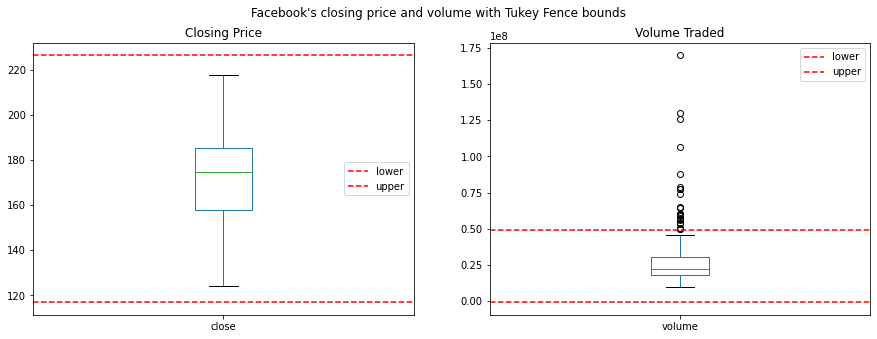

In [63]:
columns = ['close', 'volume']
subset = fb[columns]

quantiles = subset.quantile([0.25, 0.75])
quantiles.loc['iqr',:] = quantiles.loc[0.75,:] - quantiles.loc[0.25,:]

axes = subset.plot(
    kind='box', 
    subplots=True, 
    figsize=(15, 5), 
    title=['Closing Price', 'Volume Traded']
)

plt.suptitle(
    'Facebook\'s closing price and volume with Tukey Fence bounds', 
)

for ax, col in zip(axes, columns):
    stats = quantiles[col]
    lowerValue = stats.loc[0.25] - 1.5 * stats['iqr']
    upperValue = stats.loc[0.75] + 1.5 * stats['iqr']
    zippedValues = zip([lowerValue, upperValue], ['lower', 'upper'])
    for value, name in zippedValues:
        ax.axhline(
            value, 
            color='red', 
            linestyle='dashed',
            label=name
        )
        ax.legend()


# Exercise 3

Plot the evolution of cumulative COVID-19 cases worldwide, and add a dashed
vertical line on the date that it surpassed 1 million. Be sure to format the tick labels
on the y-axis accordingly

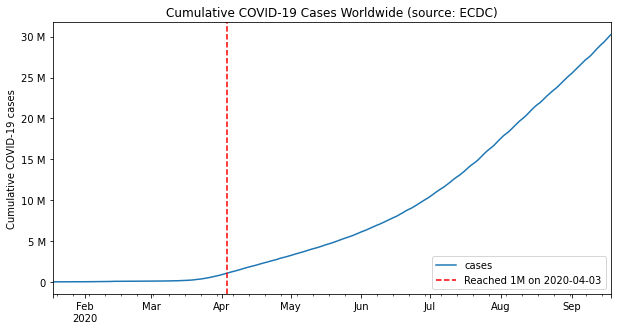

In [117]:
from matplotlib.ticker import EngFormatter


cumulativeCases = covid\
    .groupby(pd.Grouper(freq='1D')).sum()\
    .cases.cumsum()

ax = cumulativeCases.plot(
    figsize=(10, 5), 
    title='Cumulative COVID-19 Cases Worldwide (source: ECDC)'
)
ax.set(
    xlabel='', 
    ylabel='Cumulative COVID-19 cases'
)
ax.yaxis.set_major_formatter(EngFormatter())

over1M = cumulativeCases[cumulativeCases >= 1000000].index[0]
ax.axvline(
    over1M, 
    color='red', 
    linestyle='dashed',
    label=f"Reached 1M on {over1M.strftime('%Y-%m-%d')}"
)
ax.legend()


# Exercise 4

Use axvspan() to shade a rectangle from '2018-07-25' to '2018-07-31' ,
which marks the large decline in Facebook price on a line plot of the closing price.

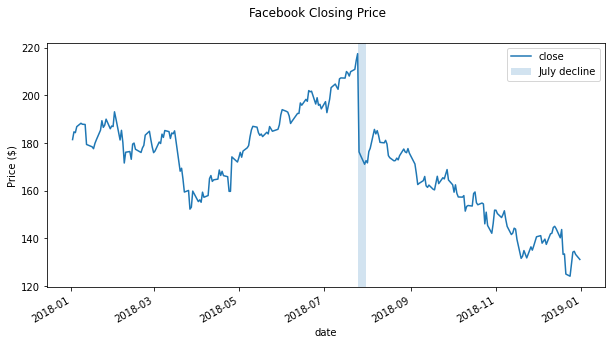

In [135]:
ax = fb.close.plot(
    kind='line', 
    figsize=(10, 5)
)

ax.axvspan(
    '2018-07-25', 
    '2018-07-31', 
    alpha=0.2,
    label='July decline'
)

plt.ylabel('Price ($)')
plt.suptitle('Facebook Closing Price')
plt.legend()

# Exercise 5



**Using the Facebook stock price data, annotate the following three events on a line
plot of the closing price**

a) Disappointing user growth announced after close on July 25, 2018

b) Cambridge Analytica story breaks on March 19, 2018 (when it affected the market)

c) FTC launches investigation on March 20, 2018

Text(0.5, 0.98, 'Facebook Closing Price')

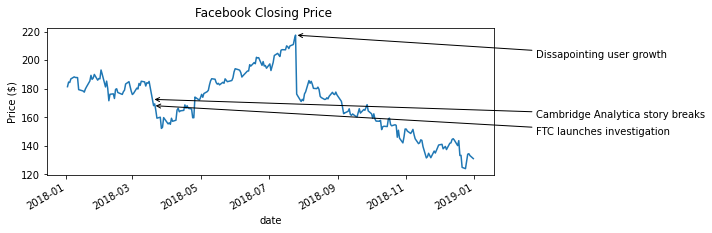

In [153]:
dates = ['2018-07-25', '2018-03-19', '2018-03-20']

events = [
    'Dissapointing user growth', 
    'Cambridge Analytica story breaks',
    'FTC launches investigation'
]

ax = fb.close.plot(
    kind='line', 
    figsize=(8, 3)
)

# Generate repeatable random jitter
np.random.seed(1)

for date, event in zip(dates, events):
    jitter = np.random.uniform(-20, -10, 1)
    closingPrice = fb.close[date]
    ax.annotate(
        event,
        xy=(date, closingPrice),
        xytext=('2019-02-25', closingPrice + jitter), # (*)
        arrowprops={'arrowstyle': '->'}
    )
# (*) Select arbitrary day on the righth side of the plot as x axis of text

plt.ylabel('Price ($)')
plt.suptitle('Facebook Closing Price')

# Exercise 6



Modify the reg_resid_plots() function to use a matplotlib colormap
instead of cycling between two colors. Remember, for this use case, we should
pick a qualitative colormap or make our own.

In [157]:
import itertools
import matplotlib.pyplot as plt
from matplotlib import cm
from seaborn import regplot, residplot


def reg_resid_plots(data):
    """
    Using `seaborn`, plot the regression and residuals
    plots side-by-side for every permutation of 2 columns 
    in the data.

    Parameters:
        - data: A `pandas.DataFrame` object

    Returns:
        A matplotlib `Axes` object.
    """
    num_cols = data.shape[1]
    permutation_count = num_cols * (num_cols - 1)

    fig, ax = plt.subplots(
        permutation_count, 
        2, 
        figsize=(15, 4 * permutation_count)
    )

    column_perms = itertools.permutations(data.columns, 2)
    color_maps = list(
        cm.Dark2(i) 
        for i in range(len(ax))
    )
    
    for (x, y), axes, color in zip(column_perms, ax, color_maps):
        for subplot, func in zip(axes, (regplot, residplot)):
            func(x=x, y=y, data=data, ax=subplot, color=color)        
            if func == residplot:
                subplot.set_ylabel('residuals') # Mark the residuals as such
    return fig.axes


[<AxesSubplot:xlabel='open', ylabel='volume'>,
 <AxesSubplot:xlabel='open', ylabel='residuals'>,
 <AxesSubplot:xlabel='volume', ylabel='open'>,
 <AxesSubplot:xlabel='volume', ylabel='residuals'>]

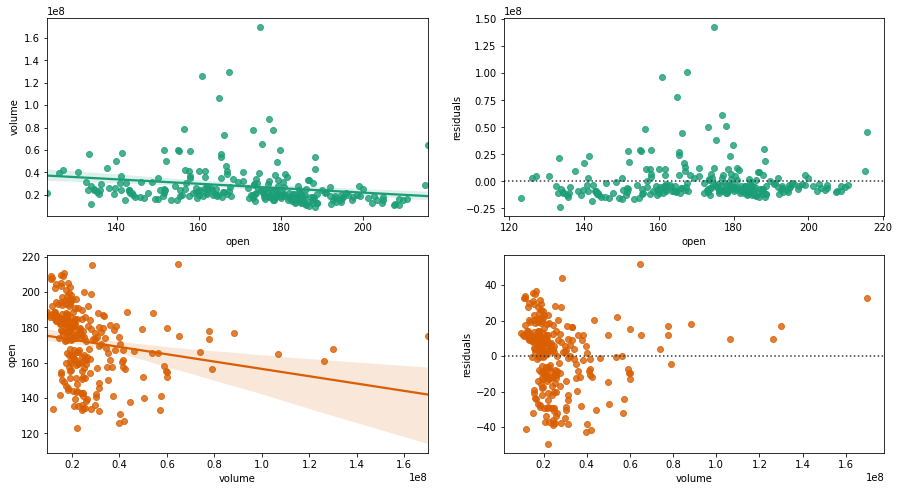

In [156]:
reg_resid_plots(fb[['open', 'volume']])

<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
        <a href="./python_101.ipynb">
            <button>Python 101</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="../../solutions/ch_01/solutions.ipynb">
            <button>Solutions</button>
        </a>
        <a href="../ch_02/1-pandas_data_structures.ipynb">
            <button>Chapter 2 &#8594;</button>
        </a>
    </div>
</div>
<hr>